In [1]:
import time
import gc

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt 

from py.tap_trial import tap_trial
from py.central_node_selector import central_node_selector

This is written to be run on a **Linux** machine. First pass evaluations are done on the Sioux Falls network for speed and per standard.

# Automate TSTT calculation for an individual OD matrix perturbation

In [2]:
df, true_tstt, true_wvc = tap_trial("inputs/SiouxFalls_net.tntp", "inputs/SiouxFalls_trips.tntp", norm_mean=1, norm_sd=0, returnDataFrame=True)
true_tstt, true_wvc

(7480171.248174683, 0.0193951334707874)

In [3]:
df.head()

,flow,cost,der,capacity
link,,,,
"(1,2)",4494.611949,6.000816,0.000001,25900.200640
"(1,3)",8119.023795,4.008691,0.000004,23403.473190
"(2,1)",4519.023795,6.000834,0.000001,25900.200640
"(2,6)",5967.349609,6.573612,0.001055,4958.180928
"(3,1)",8094.611949,4.008586,0.000004,23403.473190


In [4]:
del df

# Examine runtime of different networks

Candidate networks need to have node coordinates and run relatively quickly.

In [5]:
networks = [
#     'berlin-center',
    'friedrichshain-center',
    'berlin-mitte-center',
    'berlin-mitte-prenzlauerberg-friedrichshain-center',
    'berlin-prenzlauerberg-center',
    'berlin-tiergarten',
#     'Birmingham',
#     'ChicagoSketch',
#     'Philadelphia',
    'SiouxFalls',
#     'ChicagoRegional'
]

tap_times = {}
for net in networks:
    print(net)
    start = time.time()
    try:
        tstt, _ = tap_trial('inputs/{}_net.tntp'.format(net), 'inputs/{}_trips.tntp'.format(net), norm_mean=1, norm_sd=0)
        if tstt == 0:
            print('TAP ISSUE with', net)
            tap_times[net] = np.nan
        else:
            tap_times[net] = time.time()-start
            print(tstt)
        print('')
        del tstt
    except OSError:
        print('MEMORY ISSUE with', net)
        tap_times[net] = np.nan
    gc.collect()
tap_times

friedrichshain-center
728609.3041808964

berlin-mitte-center
1051175.476303525

berlin-mitte-prenzlauerberg-friedrichshain-center
2362496.7296204716

berlin-prenzlauerberg-center
1399925.458516812

berlin-tiergarten
716823.6964993115

SiouxFalls
7480171.248174683



{'friedrichshain-center': 0.4162755012512207,
 'berlin-mitte-center': 0.6404988765716553,
 'berlin-mitte-prenzlauerberg-friedrichshain-center': 2.2324883937835693,
 'berlin-prenzlauerberg-center': 0.6546502113342285,
 'berlin-tiergarten': 0.5213179588317871,
 'SiouxFalls': 0.07956337928771973}

# Analyze a specific network

## Scale iterations to match and find unperturbed ("true") network metrics.

In [6]:
net = 'SiouxFalls'
#     'friedrichshain-center'
#     'berlin-mitte-center'
#     'berlin-mitte-prenzlauerberg-friedrichshain-center'
#     'berlin-prenzlauerberg-center'
#     'berlin-tiergarten'
#     'SiouxFalls'

netFilename = 'inputs/{}_net.tntp'.format(net)
tripsFilename = 'inputs/{}_trips.tntp'.format(net)
    
n = 500
if tap_times[net] > 1:
    n = 100
elif tap_times[net] > .25:
    n = 200

true_tstt, true_wvc, true_demand, _ = tap_trial(netFilename, tripsFilename, norm_mean=1, norm_sd=0, returnDataFrame=False, returnODinfo=True)
true_tstt, true_wvc, true_demand

(7480171.248174683, 0.0193951334707874, 360600.0)

## Run trials for several perturbation mean and standard deviation combinations

(Except N(1,0) perturbations, since they only need one trial each.)

Avoid redoing the sampling by reading from a pre-exported csv. If it doesn't exist, then run the trials.

In [7]:
def track_ci_width_evo(netFilename, tripsFilename, n=1000):
    if n<=30:
        raise ValueError('Sample size needs to be greater than 30.')
    
    means = np.arange(0.25, 2, .25)
    sds = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

    results = {}

    for mean in means:
        results[mean] = {}
        for sd in sds:
            results[mean][sd] = {
                'tstts': np.zeros(n)*np.nan,
                'wvcs': np.zeros(n)*np.nan,
                'tstt_widths': np.zeros(n)*np.nan,
                'wvc_widths': np.zeros(n)*np.nan
            }
            for i in range(n):
                results[mean][sd]['tstts'][i], results[mean][sd]['wvcs'][i] = tap_trial(netFilename, tripsFilename, norm_mean=mean, norm_sd=sd, returnDataFrame=False)
                results[mean][sd]['tstt_widths'][i] = 4*results[mean][sd]['tstts'][0:i+1].std()/np.sqrt(i+1)
                results[mean][sd]['wvc_widths'][i] = 4*results[mean][sd]['wvcs'][0:i+1].std()/np.sqrt(i+1)
                if i>0 and results[mean][sd]['tstts'][i] > results[mean][sd]['tstts'][i-1]*1000:
                    raise ValueError('whoa nelly')
    
    # format the results into a DataFrame for easy queryign and csv export
    df_trials = pd.DataFrame(columns=['mean', 'sd', 'tstt', 'congestion'])
    df_ci_evo = pd.DataFrame(columns=['mean', 'sd', 'n', 'tstt_ci_width', 'congestion_ci_width'])
    for mean in results:
        for sd in results[mean]:
            df_trials = pd.concat([df_trials, pd.DataFrame({
                'mean': np.ones(n)*mean,
                'sd': np.ones(n)*sd,
                'tstt': results[mean][sd]['tstts'],
                'congestion': results[mean][sd]['wvcs']
            })], ignore_index=True)
            df_ci_evo = pd.concat([df_ci_evo, pd.DataFrame({
                'mean': np.ones(n)*mean,
                'sd': np.ones(n)*sd,
                'n': range(n),
                'tstt_ci_width': results[mean][sd]['tstt_widths'],
                'congestion_ci_width': results[mean][sd]['wvc_widths']
            })], ignore_index=True)
    df_trials.to_csv('output/data/{}_trials.csv'.format(net), index=False)
    df_ci_evo.to_csv('output/data/{}_ci_evo.csv'.format(net), index=False)
    return df_trials, df_ci_evo

try:
    # avoid redoing trials by reading from exports if they exist
    df_trials = pd.read_csv('output/data/{}_trials.csv'.format(net))
    df_ci_evo = pd.read_csv('output/data/{}_ci_evo.csv'.format(net))
    n = df_ci_evo['n'].max()+1
except FileNotFoundError:
    df_trials, df_ci_evo = track_ci_width_evo(netFilename, tripsFilename, n=n)
df_trials.head()

,mean,sd,tstt,congestion
0,0.25,0.001,827652.614551,0.006771
1,0.25,0.001,827952.208494,0.006771
2,0.25,0.001,827873.296005,0.006771
3,0.25,0.001,827583.158651,0.006771
4,0.25,0.001,827388.315096,0.006771


## Examine evolution of confidence interval width for increasing sample sizes

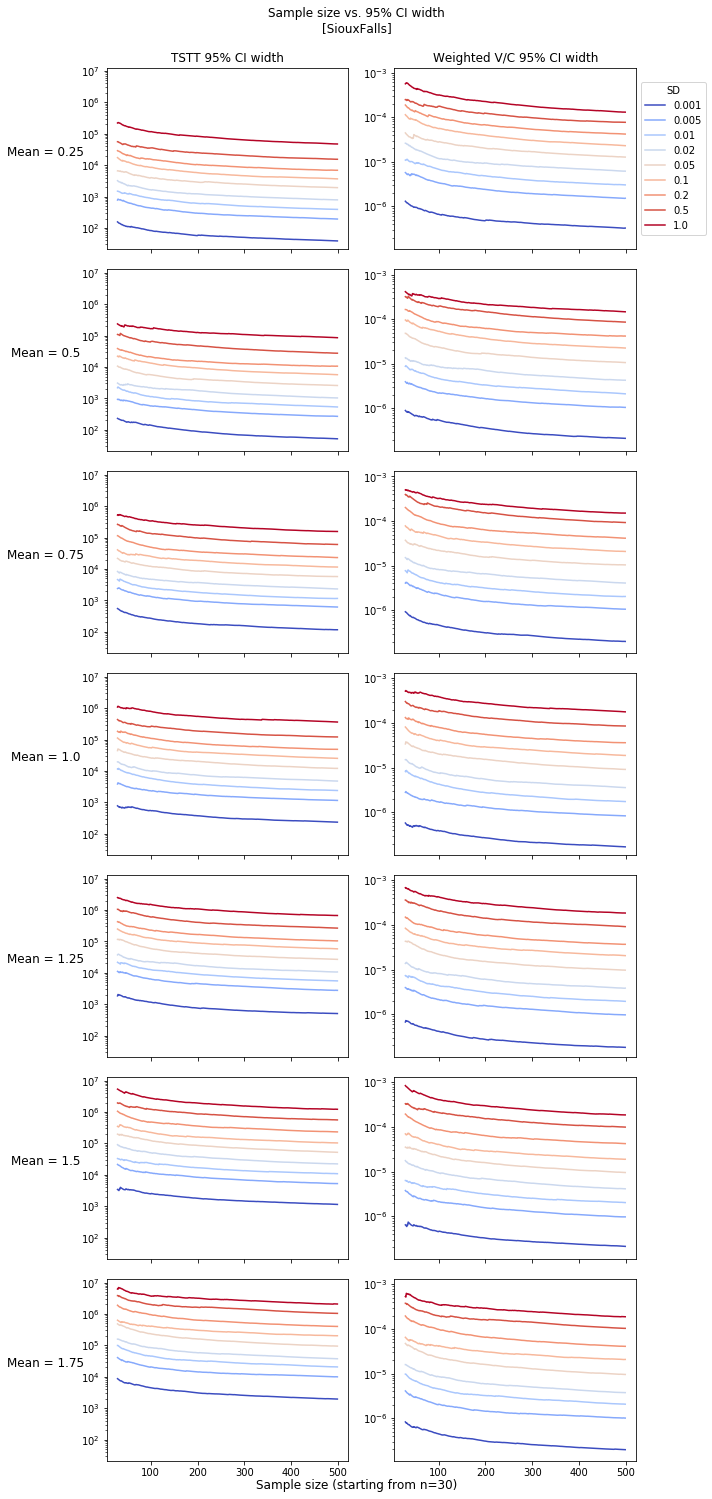

In [8]:
def plot_ci_width_evo(df_ci_evo, net, plotFilename=None):
    n = df_ci_evo['n'].max()+1
    if n<=30:
        raise ValueError('Sample size needs to be greater than 30.')
    
    means = df_ci_evo['mean'].unique()
    means.sort()
    sds = df_ci_evo['sd'].unique()
    sds.sort()

    cm = plt.get_cmap('coolwarm')

    fig, axes = plt.subplots(nrows=len(means), ncols=2, sharex=True, sharey='col', figsize=(10,len(means)*3))
    x = range(29,n)
    axes[0][0].set_title('TSTT 95% CI width')
    axes[0][1].set_title('Weighted V/C 95% CI width')
    for i,mean in enumerate(means):
        for sd in sds:
            color = 1+np.log10(sd)/3
            dftemp = df_ci_evo[(df_ci_evo['mean']==mean) & (df_ci_evo['sd']==sd)]
            axes[i][0].plot(x, dftemp['tstt_ci_width'][29:], c=cm(color), label='{}'.format(sd))
            axes[i][1].plot(x, dftemp['congestion_ci_width'][29:], c=cm(color), label='{}'.format(sd))
            axes[i][0].set_yscale('log')
            axes[i][1].set_yscale('log')
        axes[i][0].set_ylabel('Mean = {}'.format(round(mean,2)), rotation=0, size='large', labelpad=35)
    axes[0][1].legend(title='SD', loc='center left', bbox_to_anchor=(1,0.5))
    fig.suptitle('Sample size vs. 95% CI width\n[{}]'.format(net))
    fig.text(0.5, 0, 'Sample size (starting from n=30)', ha='center', fontsize=12)
    fig.tight_layout()
    fig.subplots_adjust(top=0.94)
    if plotFilename:
        plt.savefig(plotFilename, dpi='figure')
    plt.show()

plot_ci_width_evo(df_ci_evo, net, plotFilename='output/plots/{}_widths.png'.format(net))

## Compare results for different means

In [9]:
means = np.arange(0,2,.25)
reses = [tap_trial(netFilename, tripsFilename, norm_mean=mean, norm_sd=0, returnDataFrame=False) for mean in means]
tstts = np.array([r[0] for r in reses])
congestions = [r[1] for r in reses]
dfmeans = pd.DataFrame({
    'mean': means,
    'tstt': tstts,
    'congestion': congestions
})
dfmeans.to_csv('output/data/{}_trials_means_only.csv'.format(net), index=False)
dfmeans.head()

,mean,tstt,congestion
0,0.00,0.000000e+00,NaN
1,0.25,8.277958e+05,0.006772
2,0.50,1.870592e+06,0.010908
3,0.75,3.654464e+06,0.015076
4,1.00,7.480171e+06,0.019395


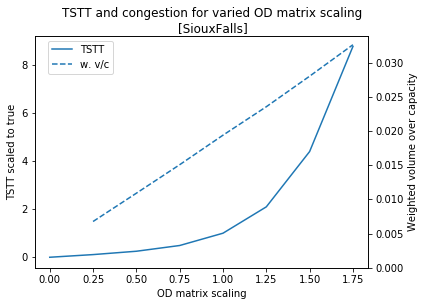

In [10]:
def tstt_wvc_plot(inputs, tstts, congestions, input_name, net, log_input=False, log_tstt=False, output_fig_name=None):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel(input_name)
    ax1.set_ylabel('TSTT scaled to true')
    ax1.plot(inputs, tstts, label='TSTT')
    if log_input:
        ax1.set_xscale('log')
    if log_tstt:
        ax1.set_yscale('log')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Weighted volume over capacity')
    ax2.plot(inputs, congestions, linestyle='--', label='w. v/c')
    ax2.set_ylim(bottom=0)

    fig.legend(loc=1, bbox_to_anchor=(0.25,1), bbox_transform=ax1.transAxes)
    fig.suptitle('TSTT and congestion for varied {}\n[{}]'.format(input_name,net), y=1.05)
    fig.tight_layout()
    if output_fig_name:
        plt.savefig(output_fig_name, dpi='figure')
    plt.show()

tstt_wvc_plot(means, tstts/true_tstt, congestions, 'OD matrix scaling', net, log_tstt=False, output_fig_name='output/plots/{}_mean_scaling.png'.format(net))

## Compare results for different standard deviations

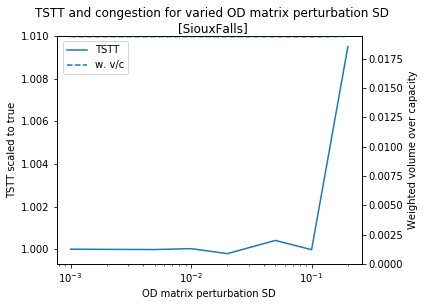

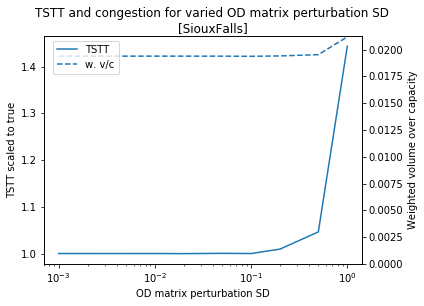

In [11]:
sds = df_trials['sd'].unique()
sds.sort()
tstts_scaled = np.array([df_trials[(df_trials['mean']==1) & (df_trials['sd']==sd)]['tstt'].mean() for sd in sds])/true_tstt
congestions = np.array([df_trials[(df_trials['mean']==1) & (df_trials['sd']==sd)]['congestion'].mean() for sd in sds])
tstt_wvc_plot(sds[:-2], tstts_scaled[:-2], congestions[:-2], 'OD matrix perturbation SD', net, log_input=True, output_fig_name='output/plots/{}_stdv_scaling.png'.format(net))
tstt_wvc_plot(sds, tstts_scaled, congestions, 'OD matrix perturbation SD', net, log_input=True, output_fig_name='output/plots/{}_stdv_scaling.png'.format(net))

## Visualize Monte Carlo trials

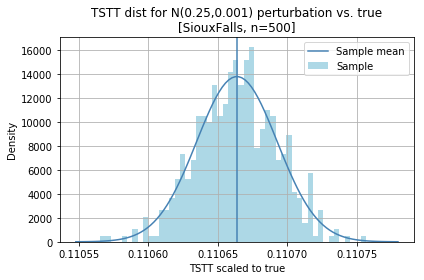

  true mean: 7480171.248174683
sample mean: 827784.3496313888
sample stdv: 216.6942862067041
  shapiro p: 0.9741336703300476
% in 95% CI: 0.96



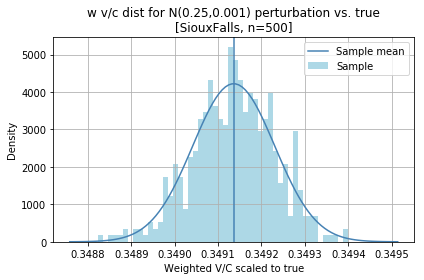

  true mean: 0.0193951334707874
sample mean: 0.006771540861461526
sample stdv: 1.8322600186827935e-06
  shapiro p: 0.3375990688800812
% in 95% CI: 0.962


,mean,sd,tstt_mean,tstt_sd,tstt_p,wvc_mean,wvc_sd,wvc_p
0,0.25,0.001,827784.349631,216.694286,0.974134,0.006772,0.000002,0.337599
1,0.25,0.005,827725.013945,1075.490818,0.308665,0.006771,0.000009,0.182925
2,0.25,0.010,827697.403619,2180.932287,0.508618,0.006769,0.000017,0.050090
3,0.25,0.020,827672.778836,4377.696834,0.939363,0.006762,0.000035,0.009638
4,0.25,0.050,827157.283142,10707.529053,0.325379,0.006734,0.000071,0.064534


In [12]:
def visualize(data, mean_true, plot_true_mean=True, xlabel='TSTT scaled to true', img_title=None, img_filename=None, verbose_output=False):
    mean_sample = data.mean()
    sd = data.std()
    plt.figure()
    
    mean_sample_normed = mean_sample/mean_true
    sd_normed = sd/mean_true
    xsnorm = np.linspace(mean_sample_normed - 4*sd_normed, mean_sample_normed + 4*sd_normed, 100)

    (data/mean_true).hist(bins=min([len(data)//10,100]), label='Sample', color='lightblue', density=True)
    if plot_true_mean:
        plt.axvline(x=1, color='orange')
        xtnorm = np.linspace(1 - 4*sd_normed, 1 + 4*sd_normed, 100)
        plt.plot(xtnorm, stats.norm.pdf(xtnorm, 1, sd_normed), color='orange', label='True mean')
    plt.axvline(x=mean_sample_normed, color='steelblue')
    plt.plot(xsnorm, stats.norm.pdf(xsnorm, mean_sample_normed, sd_normed), color='steelblue', label='Sample mean')
    
    if img_title:
        plt.title(img_title)
    plt.ylabel('Density')
    plt.xlabel(xlabel)
    plt.legend()
    plt.tight_layout()
    if img_filename:
        plt.savefig(img_filename, dpi='figure')
    
    if verbose_output:
        plt.show()
        print('  true mean:', mean_true)
        print('sample mean:', mean_sample)
        print('sample stdv:', sd)
    else:
        plt.close()
    
    return mean_sample, sd

def test_perturbation_pair(
    df,
    
    norm_mean,
    norm_sd,
    
    tstt_true,
    wvc_true,
    
    net_name=None,
    plot_true_mean=True,
    verbose_output=False
):
    
    dft = df.loc[np.isclose(df_trials['mean'],norm_mean) & np.isclose(df_trials['sd'],norm_sd)]
    n = len(dft)
    
    tstts = dft['tstt']
    tstt_mean, tstt_sd = visualize(tstts, tstt_true, plot_true_mean, 
                                   img_title='TSTT dist for N({},{}) perturbation vs. true\n[{}, n={}]'.format(norm_mean, norm_sd, net_name, n), 
                                   img_filename='output/plots/{}_tstt_N({}, {})_n{}.png'.format(net_name, norm_mean, norm_sd, n), verbose_output=verbose_output)
    tstt_pvalue = stats.shapiro(tstts)[1]
    if verbose_output:
        print('  shapiro p:', tstt_pvalue)
        print('% in 95% CI:', ((tstts > tstt_mean-2*tstt_sd) & (tstts < tstt_mean+2*tstt_sd)).sum()/len(tstts))
        print('')
    
    wvcs = dft['congestion']
    wvc_mean, wvc_sd = visualize(wvcs, wvc_true, plot_true_mean, xlabel='Weighted V/C scaled to true',
                                 img_title='w v/c dist for N({},{}) perturbation vs. true\n[{}, n={}]'.format(norm_mean, norm_sd, net_name, n), 
                                 img_filename='output/plots/{}_wvc_N({}, {})_n{}.png'.format(net_name, norm_mean, norm_sd, n), verbose_output=verbose_output)
    wvc_pvalue = stats.shapiro(wvcs)[1]
    if verbose_output:
        print('  shapiro p:', wvc_pvalue)
        print('% in 95% CI:', ((wvcs > wvc_mean-2*wvc_sd) & (wvcs < wvc_mean+2*wvc_sd)).sum()/len(wvcs))
    
    return tstt_mean, tstt_sd, tstt_pvalue, wvc_mean, wvc_sd, wvc_pvalue

def plot_all_pairs(df_trials, true_tstt, true_wvc, net):
    means = df_trials['mean'].unique()
    means.sort()
    sds = df_trials['sd'].unique()
    sds.sort()
    
    df_pairs = pd.DataFrame(columns=['mean', 'sd', 'tstt_mean', 'tstt_sd', 'tstt_p', 'wvc_mean', 'wvc_sd', 'wvc_p'])
    
    k=0
    for i,mean in enumerate(means):
        for sd in sds:
            tstt_mn, tstt_sd, tstt_p, wvc_mn, wvc_sd, wvc_p = test_perturbation_pair(df_trials,
                                                                                     mean, sd,
                                                                                     true_tstt, true_wvc,
                                                                                     net_name=net,
                                                                                     plot_true_mean=(mean==1),
                                                                                     verbose_output=(k==0))
            df_pairs.loc[k] = {
                'mean': mean,
                'sd': sd,
                'tstt_mean': tstt_mn,
                'tstt_sd': tstt_sd,
                'tstt_p': tstt_p,
                'wvc_mean': wvc_mn,
                'wvc_sd': wvc_sd,
                'wvc_p': wvc_p
            }
            k+=1
    
    df_pairs.to_csv('output/data/{}_monte_carlo.csv'.format(net), index=False)
    
    return df_pairs

df_pairs = plot_all_pairs(df_trials, true_tstt, true_wvc, net)
df_pairs.head()

## Perturb a subset of nodes

How does TSTT change when we perturb only a subset of all nodes?

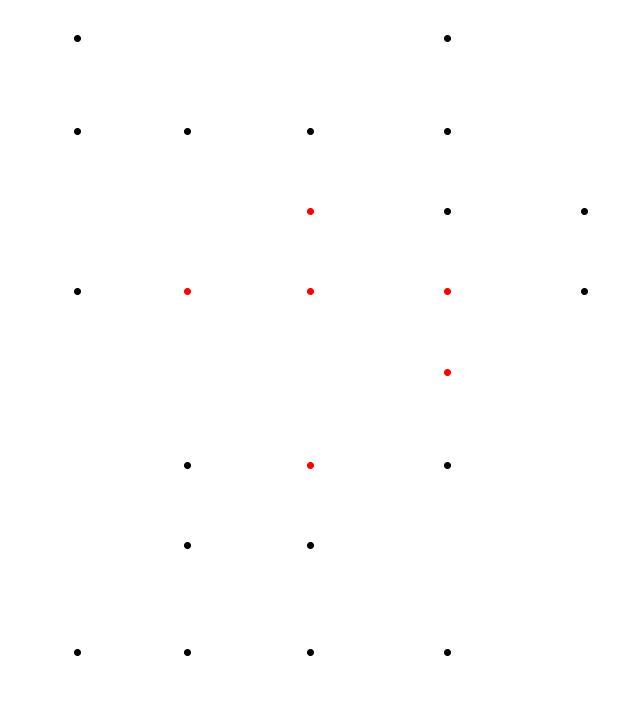

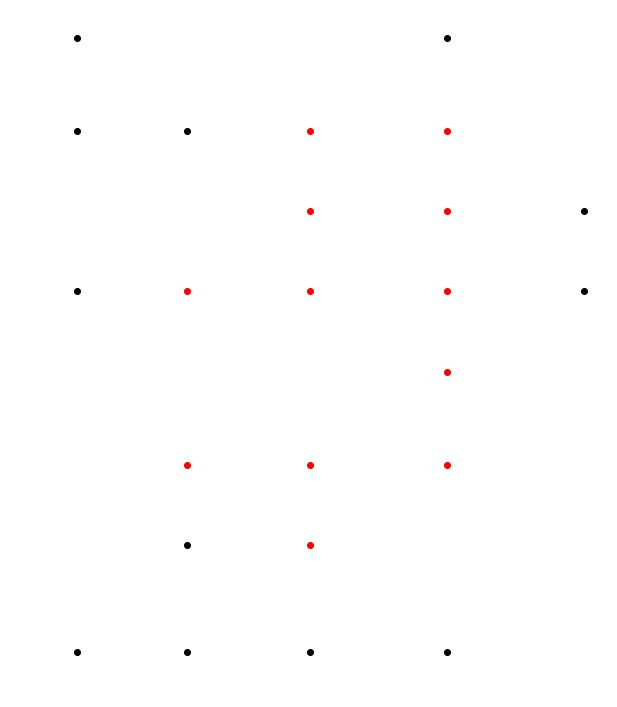

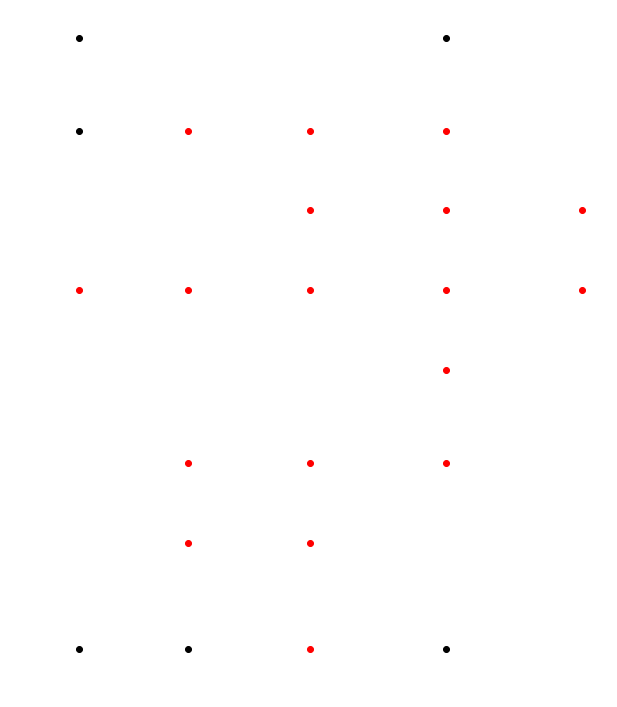

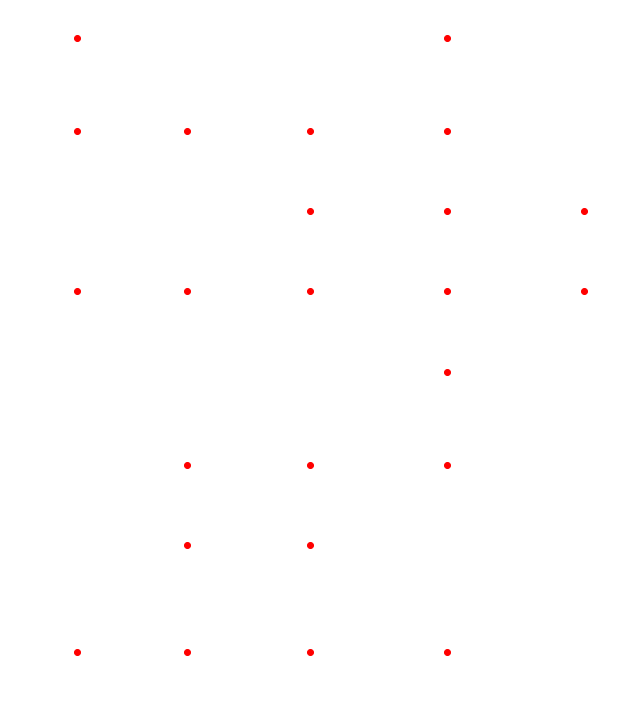

,mean,p,method,tstt,congestion
0,0.5,0.25,Origin,4.429737e+06,0.016169
1,0.5,0.25,Destination,4.430935e+06,0.016174
2,0.5,0.25,Both,2.949053e+06,0.013645
3,0.5,0.50,Origin,3.241227e+06,0.014173
4,0.5,0.50,Destination,3.241529e+06,0.014173


In [13]:
def partial_perturber(netFilename, tripsFilename, nodeFilename, proportion, norm_mean=1, norm_sd=0, show_plot=False):
    '''
    Perturb <proportion> of zones closest to geographic center by Euclidean distance.
    Note that we perturb only zones (nodes with origin and destination flow), but that
    we measure by proportion of all nodes and only then filter for just zones.
    '''
    nodes_to_perturb = central_node_selector(nodeFilename, proportion, make_plot=show_plot, show_plot=show_plot)
    if show_plot:
        nodes_to_perturb = nodes_to_perturb[0]
    
    tstt = [None]*3
    congestion = [None]*3
    tstt[0], congestion[0] = tap_trial(netFilename, tripsFilename, norm_mean=norm_mean, norm_sd=norm_sd, returnDataFrame=False,
                                       nodesPerturbedIfOrig=nodes_to_perturb)
    tstt[1], congestion[1] = tap_trial(netFilename, tripsFilename, norm_mean=norm_mean, norm_sd=norm_sd, returnDataFrame=False,
                                       nodesPerturbedIfDest=nodes_to_perturb)
    tstt[2], congestion[2] = tap_trial(netFilename, tripsFilename, norm_mean=norm_mean, norm_sd=norm_sd, returnDataFrame=False,
                                       nodesPerturbedAlways=nodes_to_perturb)
    return tstt, congestion


def partial_perturber_sim(netFilename, tripsFilename, nodeFilename, net):
    
    df = pd.DataFrame(columns=['mean', 'p', 'method', 'tstt', 'congestion'])
    counter = 0
    
    means = np.arange(.5, 1.6, .25)
    means = means[means != 1]
    ps = np.arange(.25, 1.1, .25)
    methods = ['Origin', 'Destination', 'Both']
    
    for k,mean in enumerate(means):
        if mean==1:
            continue
        for p in ps:
            tstt, congestion = partial_perturber(netFilename, tripsFilename, nodeFilename, p, norm_mean=mean, show_plot=(k==0))
            for i,method in enumerate(methods):
                df.loc[counter]={
                    'mean': mean,
                    'p': p,
                    'method': method,
                    'tstt': tstt[i],
                    'congestion': congestion[i]
                }
                counter += 1
    
    df.to_csv('output/data/{}_trials_partial_perturb.csv'.format(net), index=False)
    
    return df

nodeFilename = 'inputs/{}_node.tntp'.format(net)
# try:
#     df_partial = pd.read_csv('output/data/{}_trials_partial_perturb.csv'.format(net))
# except FileNotFoundError:
#     df_partial = partial_perturber_sim(netFilename, tripsFilename, nodeFilename, net)
df_partial = partial_perturber_sim(netFilename, tripsFilename, nodeFilename, net)
df_partial.head()

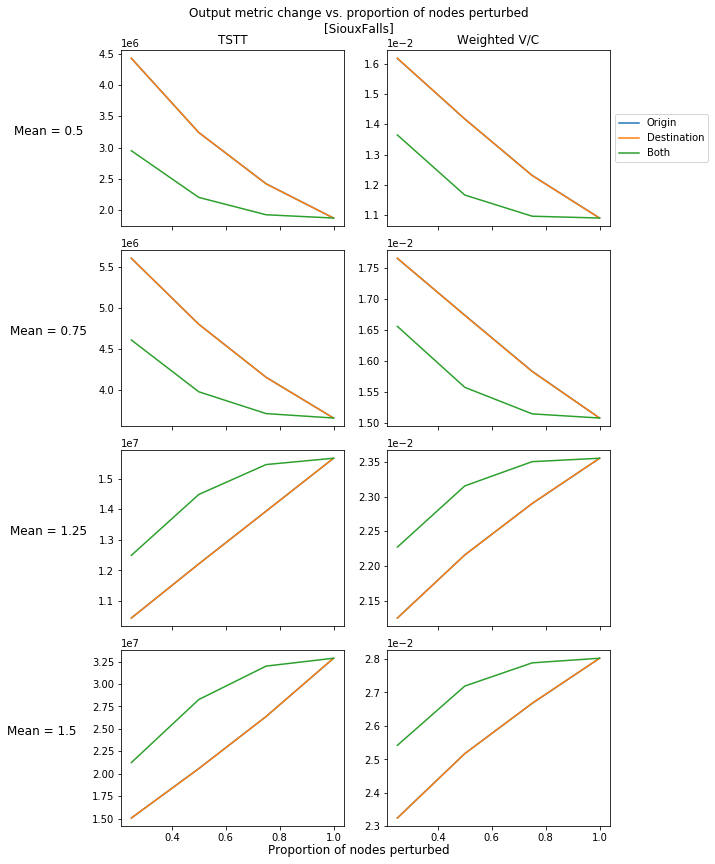

In [14]:
def partial_perturb_plotter(df, net, plotFilename=None):
    means = df['mean'].unique()
    means.sort()
    ps = df['p'].unique()
    ps.sort()
    methods = df['method'].unique()
    methods.sort()
    methods = np.flip(methods)
    
    fig, axes = plt.subplots(nrows=len(means), ncols=2, sharex=True, figsize=(10,len(means)*3))
    
    axes[0][0].set_title('TSTT')
    axes[0][1].set_title('Weighted V/C')
    for i,mean in enumerate(means):
        for j,method in enumerate(methods):
            axes[i][0].plot(ps, df.loc[(df['mean']==mean) & (df['method']==method),'tstt'], label=method)
            axes[i][1].plot(ps, df.loc[(df['mean']==mean) & (df['method']==method),'congestion'], label=method)
            axes[i][0].ticklabel_format(style='sci', scilimits=(0,0))
            axes[i][1].ticklabel_format(style='sci', scilimits=(0,0))
            axes[i][0].set_ylabel('Mean = {}'.format(round(mean,2)), rotation=0, size='large', labelpad=50)
    axes[0][1].legend(loc='center left', bbox_to_anchor=(1,0.5))
    
    fig.suptitle('Output metric change vs. proportion of nodes perturbed\n[{}]'.format(net))
    fig.text(0.5, 0, 'Proportion of nodes perturbed', ha='center', fontsize=12)
    fig.tight_layout()
    fig.subplots_adjust(top=0.93)
    if plotFilename:
        plt.savefig(plotFilename, dpi='figure')
    plt.show()

partial_perturb_plotter(df_partial, net, plotFilename='output/plots/{}_partial_perturb.png'.format(net))

### Sectional perturbation vs. global perturbation with matching demand

Suppose we perturb the 50% of nodes closest to the center of a net, then compare with an OD matrix that has been globally scaled to match the demand. How do the output metrics work out?

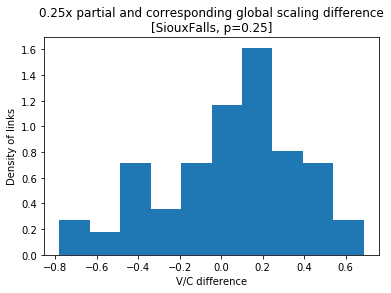

,mean,proportion,demand,tstt_partial,tstt_comp,wvc_partial,wvc_comp
0,0.25,0.25,244650.0,3.639556e+06,2.997721e+06,0.014978,0.013850
1,0.25,0.50,183375.0,2.338017e+06,1.913946e+06,0.012367,0.011050
2,0.25,0.75,132450.0,1.411532e+06,1.265175e+06,0.009172,0.008638
3,0.25,1.00,90150.0,8.277958e+05,8.277958e+05,0.006772,0.006772
4,0.50,0.25,283300.0,4.429737e+06,4.052286e+06,0.016169,0.015727


In [15]:
def progressive_partial_perturbation(netFilename, tripsFilename, nodeFilename, true_demand, net, verbose=False):
    df = pd.DataFrame(columns=['mean', 'proportion', 'demand', 'tstt_partial', 'tstt_comp', 'wvc_partial', 'wvc_comp'])
    
    i = 0
    for m in np.arange(.25, 2, .25):
        for p in np.arange(.25, 1.1, .25):
            nodes_to_perturb = central_node_selector(nodeFilename, p, make_plot=False)
            dfp, tsttp, wvcp, demand, od1p5 = tap_trial(netFilename, tripsFilename, norm_mean=m, 
                                                         norm_sd=0, returnDataFrame=True, returnODinfo=True, 
                                                         nodesPerturbedIfOrig=nodes_to_perturb)
            dfc, tsttc, wvcc = tap_trial(netFilename, tripsFilename, norm_mean=demand/true_demand,
                                         norm_sd=0, returnDataFrame=True, returnODinfo=False)
            df.loc[i] = {
                'mean': m,
                'proportion': p,
                'demand': demand,
                'tstt_partial': tsttp,
                'tstt_comp': tsttc,
                'wvc_partial': wvcp,
                'wvc_comp': wvcc
            }
            i += 1
            
            ((dfp['flow']-dfc['flow'])/dfc['capacity']).hist(density=True)
            plt.title('{}x partial and corresponding global scaling difference\n[{}, p={}]'.format(m, net, p))
            plt.xlabel('V/C difference')
            plt.ylabel('Density of links')
            plt.grid(b=None)
            plt.savefig('output/plots/{}_._{}x_p{}.png', dpi='figure')
            if verbose or i==1:
                plt.show()
            else:
                plt.close()
    df.to_csv('output/data/{}_ppp.csv'.format(net), index=False)
    
    return df

df_ppp = progressive_partial_perturbation(netFilename, tripsFilename, nodeFilename, true_demand, net, verbose=False)
df_ppp.head()